## 1D Model

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import torch
from botorch.models import SingleTaskGP, ModelListGP
from botorch.fit import fit_gpytorch_model
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.acquisition.analytic import UpperConfidenceBound, ProbabilityOfImprovement
from botorch.optim import optimize_acqf
from botorch.cross_validation import gen_loo_cv_folds
import math
import GPy

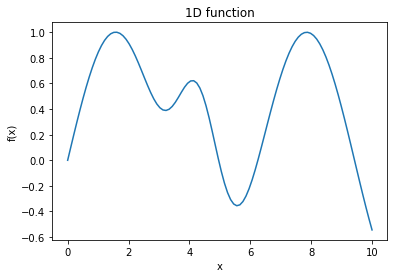

In [55]:
def f(X):
    y = []
    for x in X:
        y.append(np.sin(x) + 1.5 * np.exp(-(x - 4.3) ** 2))
    return torch.tensor(np.array(y))


bounds = np.array([[0., 10.]])
fig, ax = plt.subplots()
x = np.linspace(bounds[0, 0], bounds[0, 1], 100)
y_true = np.array([f(np.atleast_2d(xi)) for xi in x])
ax.plot(x, y_true)
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.set_title('1D function')
plt.show()

## Retrieve initial dataset to start with

In [56]:
def generate_init_data(n):
    train_x = torch.rand(n, 1)
    exact_objective = f(train_x).unsqueeze(-1)
    best_observation = exact_objective.max().item()
    return train_x, exact_objective, best_observation

init_data_no = 20

init_x, init_y, best_init_y = generate_init_data(init_data_no)
bounds = torch.tensor([[0.], [10.]])
print(f"intial x values:{init_x}",\
      f"initial y values:{init_y}", \
      f"Best initial y:{best_init_y}")


intial x values:tensor([[0.6503],
        [0.1705],
        [0.8158],
        [0.3529],
        [0.0327],
        [0.3641],
        [0.9451],
        [0.3450],
        [0.9256],
        [0.3642],
        [0.9540],
        [0.2865],
        [0.3564],
        [0.4381],
        [0.5643],
        [0.5592],
        [0.2257],
        [0.1509],
        [0.7755],
        [0.9386]]) initial y values:tensor([[0.6054],
        [0.1697],
        [0.7283],
        [0.3456],
        [0.0327],
        [0.3561],
        [0.8106],
        [0.3382],
        [0.7990],
        [0.3562],
        [0.8157],
        [0.2826],
        [0.3489],
        [0.4242],
        [0.5348],
        [0.5305],
        [0.2238],
        [0.1503],
        [0.7000],
        [0.8067]]) Best initial y:0.815746545791626


tensor([[ 0.],
        [10.]])

## EI

In [45]:
def generate_next_sample(init_x, init_y, best_init_y, bounds, n):
    model = SingleTaskGP(init_x, init_y)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    EI = qExpectedImprovement(
        model=model,
        best_f=best_init_y)
    next_sample, _ = optimize_acqf(
        acq_function=EI,
        bounds=bounds,
        q=n,
        num_restarts=200,
        raw_samples=512,
        options={"batch_limit": 5, "maxiter": 200})
    return next_sample


n_runs = 5 # no. of BO runs
for i in range(n_runs):
    print(f"No. of optimisation runs:{i}")
    next_sample = generate_next_sample(init_x, init_y, best_init_y, bounds, n=1)
    new_result = f(next_sample).unsqueeze(-1)

    print(f"The next sample is: {next_sample}")

    init_x = torch.cat([init_x, next_sample])
    init_y = torch.cat([init_y, new_result])
    best_init_y = init_y.max().item()
    print(f"Best point performed: {best_init_y}")

No. of optimisation runs:0
The next sample is: tensor([[2.0717]])
Best point performed: 0.8876107335090637
No. of optimisation runs:1
The next sample is: tensor([[1.5509]])
Best point performed: 1.000584602355957
No. of optimisation runs:2
The next sample is: tensor([[10.]])
Best point performed: 1.000584602355957
No. of optimisation runs:3
The next sample is: tensor([[4.0962]])
Best point performed: 1.000584602355957
No. of optimisation runs:4
The next sample is: tensor([[6.0513]])
Best point performed: 1.000584602355957


## PI

In [51]:
def generate_next_sample(init_x, init_y, best_init_y, bounds, n):
    model = SingleTaskGP(init_x, init_y)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    PI = ProbabilityOfImprovement(
        model=model,
        best_f=best_init_y)
    next_sample, _ = optimize_acqf(
        acq_function=PI,
        bounds=bounds,
        q=n,
        num_restarts=200,
        raw_samples=512,
        options={"batch_limit": 5, "maxiter": 200})
    return next_sample


n_runs = 20 # no. of BO runs
for i in range(n_runs):
    print(f"No. of optimisation runs:{i}")
    next_sample = generate_next_sample(init_x, init_y, best_init_y, bounds, n=1)
    new_result = f(next_sample).unsqueeze(-1)

    print(f"The next sample is: {next_sample}")

    init_x = torch.cat([init_x, next_sample])
    init_y = torch.cat([init_y, new_result])
    best_init_y = init_y.max().item()
    print(f"Best point performed: {best_init_y}")

No. of optimisation runs:0
The next sample is: tensor([[1.0117]])
Best point performed: 0.8477461338043213
No. of optimisation runs:1
The next sample is: tensor([[1.1173]])
Best point performed: 0.8989976644515991
No. of optimisation runs:2
The next sample is: tensor([[1.2204]])
Best point performed: 0.9393410086631775
No. of optimisation runs:3
The next sample is: tensor([[1.3265]])
Best point performed: 0.9705315828323364
No. of optimisation runs:4
The next sample is: tensor([[1.4261]])
Best point performed: 0.989935576915741
No. of optimisation runs:5
The next sample is: tensor([[1.5127]])
Best point performed: 0.9989496469497681
No. of optimisation runs:6
The next sample is: tensor([[1.5735]])
Best point performed: 1.000882863998413
No. of optimisation runs:7
The next sample is: tensor([[1.5929]])
Best point performed: 1.000882863998413
No. of optimisation runs:8
The next sample is: tensor([[1.5887]])
Best point performed: 1.000882863998413
No. of optimisation runs:9
The next sampl

## Result Visualisation

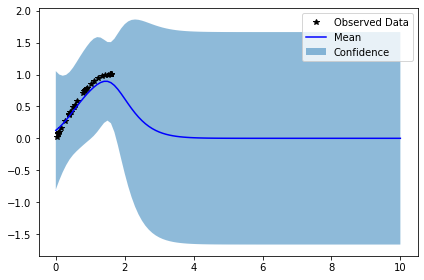

In [52]:
model = SingleTaskGP(init_x, init_y)
model.eval()

# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(6, 4))
# test model on 101 regular spaced points on the interval [0, 10]
test_x = torch.linspace(0, 10, 101)
# no need for gradients
with torch.no_grad():
    # compute posterior
    posterior = model.posterior(test_x)
    # Get upper and lower confidence bounds (2 standard deviations from the mean)
    lower, upper = posterior.mvn.confidence_region()
    # Plot training points as black stars
    ax.plot(init_x.cpu().numpy(), init_y.cpu().numpy(), 'k*')
    # Plot posterior means as blue line
    ax.plot(test_x.cpu().numpy(), posterior.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
ax.legend(['Observed Data', 'Mean', 'Confidence'])
plt.tight_layout()
plt.show()